# Deep Dream Images

Convoutional Neural Networks (CNN) are state of the art algorithms for computer vision and image processing.  Deep Dream processing takes an image (ducks on the left) and creates a crazy Deep Dream image (on the right):

![Staring image](ducks-start-end.png)

Here is some backgound from Stanford's [cs231n](http://cs231n.stanford.edu/) class:

>In the summer of 2015, Google released a [blog post](http://googleresearch.blogspot.com/2015/06/inceptionism-going-deeper-into-neural.html) describing a new method of generating images from neural networks, and they later [released code](https://github.com/google/deepdream) to generate these images.

>The idea is very simple. We pick some layer from the network, pass the starting image through the network to extract features at the chosen layer, set the gradient at that layer equal to the activations themselves, and then backpropagate to the image. This has the effect of modifying the image to amplify the activations at the chosen layer of the network.

>For DeepDream we usually extract features from one of the convolutional layers, allowing us to generate images of any resolution.

>We can implement this idea using our pretrained network. The results probably won't look as good as Google's since their network is much bigger, but we should still be able to generate some interesting images.

I generated a few Deep Dream images using a combination of python code I wrote and code supplied by cs231.  This notebook shows the python code and generated images.  



In [7]:
import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

def deepdream(X, layer, model, **kwargs):
  """
  Generate a DeepDream image.
  
  Inputs:
  - X: Starting image, of shape (1, 3, H, W)
  - layer: Index of layer at which to dream
  - model: A PretrainedCNN object
  
  Keyword arguments:
  - learning_rate: How much to update the image at each iteration
  - max_jitter: Maximum number of pixels for jitter regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the generated image
  """
  
  X = X.copy()
  
  learning_rate = kwargs.pop('learning_rate', 5.0)
  max_jitter = kwargs.pop('max_jitter', 16)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 25)
  
  for t in xrange(num_iterations):
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX using the DeepDream method. You'll   #
    # need to use the forward and backward methods of the model object to      #
    # extract activations and set gradients for the chosen layer. After        #
    # computing the image gradient dX, you should use the learning rate to     #
    # update the image X.                                                      #
    ############################################################################
    scores, cache = model.forward(X, end=layer)
    dx, grads = model.backward(scores, cache)
    X += learning_rate * dx
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    mean_pixel = data['mean_image'].mean(axis=(1, 2), keepdims=True)
    X = np.clip(X, -mean_pixel, 255.0 - mean_pixel)
    
    # Periodically show the image
    if t == 0 or (t + 1) % show_every == 0:
      img = deprocess_image(X, data['mean_image'], mean='pixel')
      plt.imshow(img)
      plt.title('t = %d' % (t + 1))
      plt.gcf().set_size_inches(8, 8)
      plt.axis('off')
      plt.show()
  return X

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


## From start to finish

This cell shows the progression of a starting image into a well developed deep dream image.   In this case the starting image is from an awards ceremony for the [Mille Lacs Kite Crossing](http://fleet8.com/) snow kite race. 
The staring image turns into something soft and squishy.

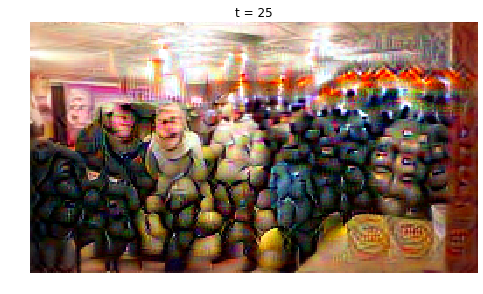

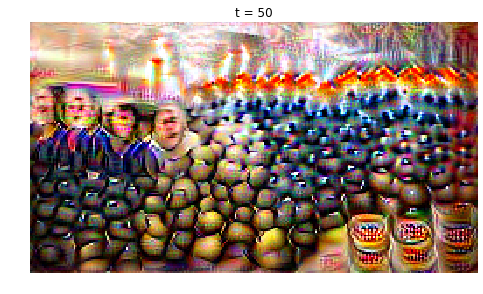

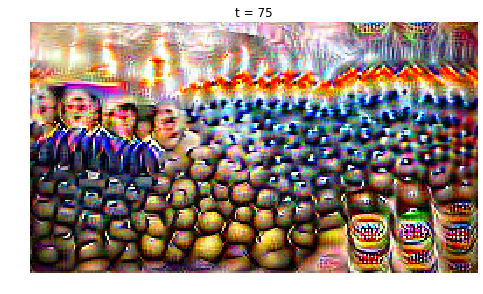

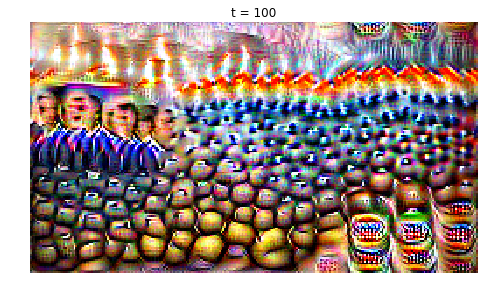

In [8]:
def read_image(filename, max_size):
  """
  Read an image from disk and resize it so its larger side is max_size
  """
  img = imread(filename)
  H, W, _ = img.shape
  if H >= W:
    img = imresize(img, (max_size, int(W * float(max_size) / H)))
  elif H < W:
    img = imresize(img, (int(H * float(max_size) / W), max_size))
  return img

filename = '2016-03-04 20.30.27.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, 
                learning_rate=1e4, 
                num_iterations=100)

## From soothing to disturbing

The follow deep dream progression starts with a soothing winter image taken at dusk near Jakson Hole, WY.  I find the Deep Dream images disturbing as they remind me of visual glitches associated with the onset of a migrane headache.

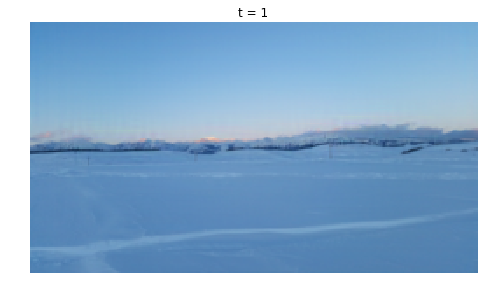

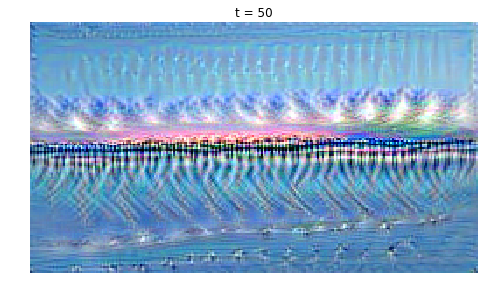

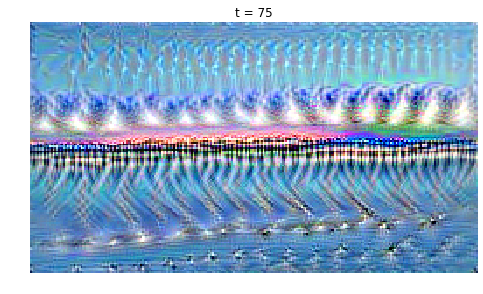

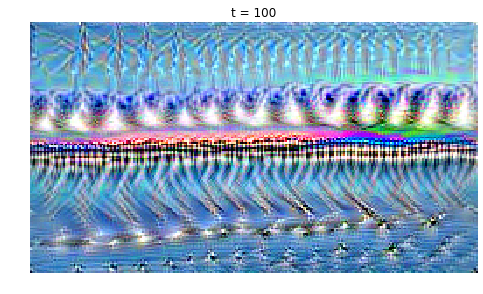

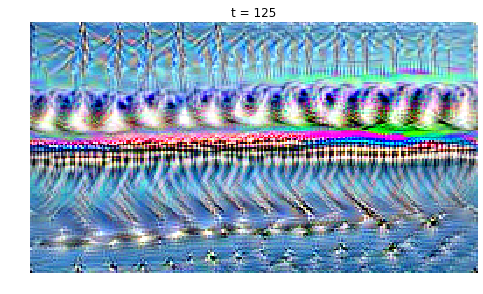

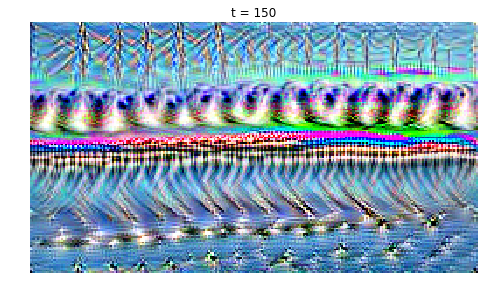

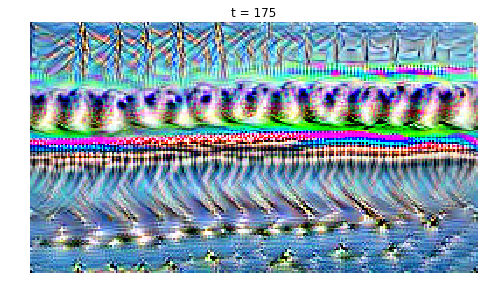

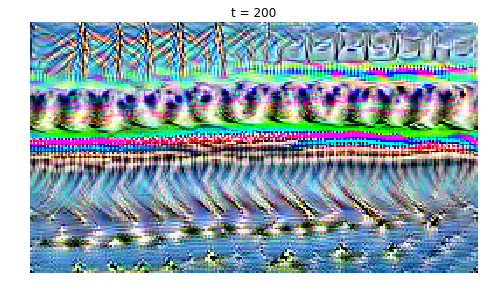

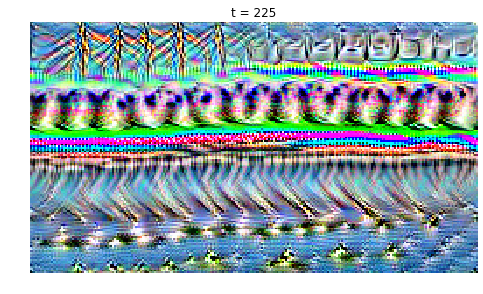

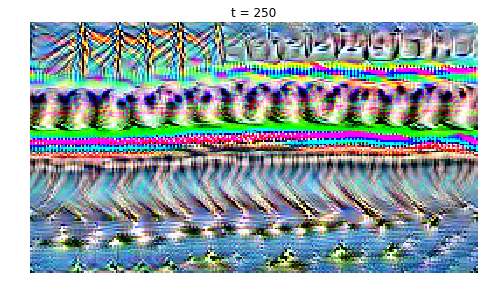

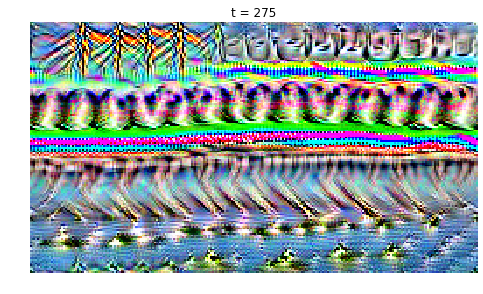

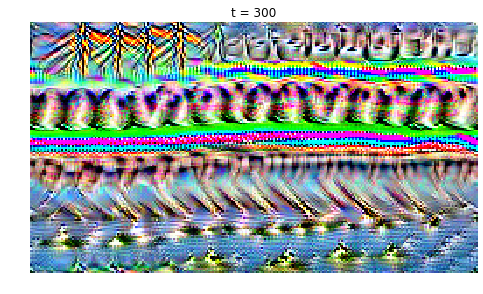

In [9]:
filename = '20160202_172938.jpg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, 
                learning_rate=1e4, 
                num_iterations=300)

# Ducks to Antelope

The most striking feature of this progression is the emergence of antelope and dog's heads.  The network used in this example was trained on a sub-set of [Image Net](image-net.org) which contains a lot of animal pictures.

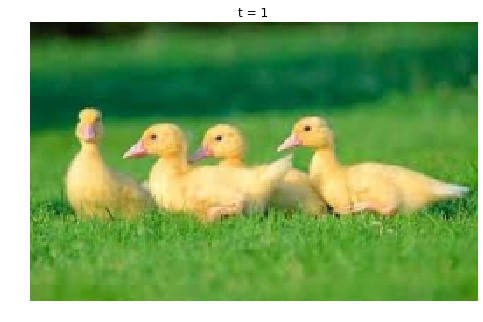

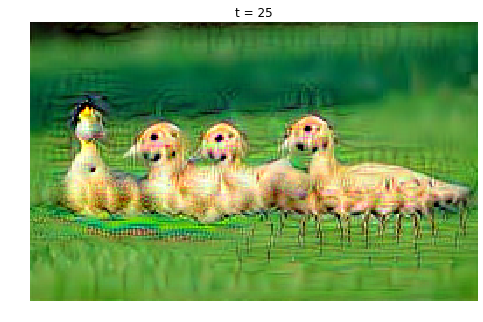

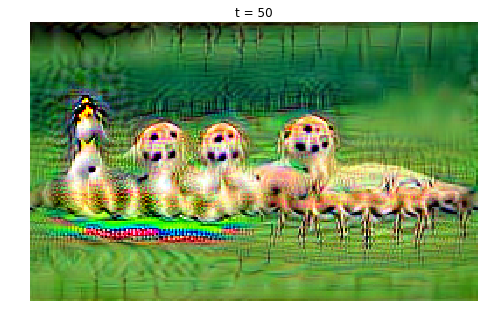

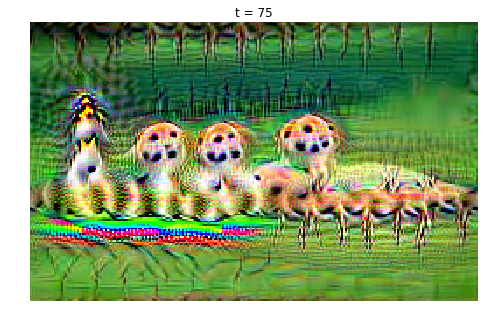

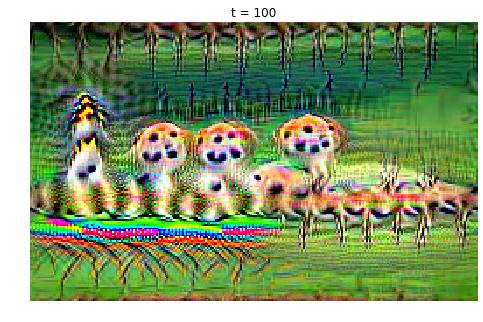

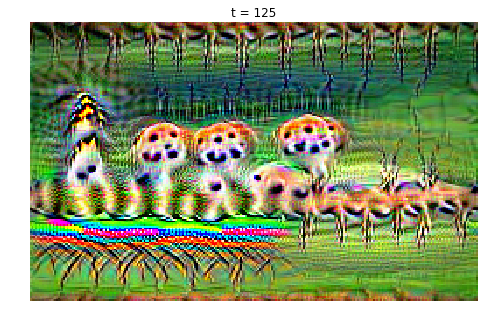

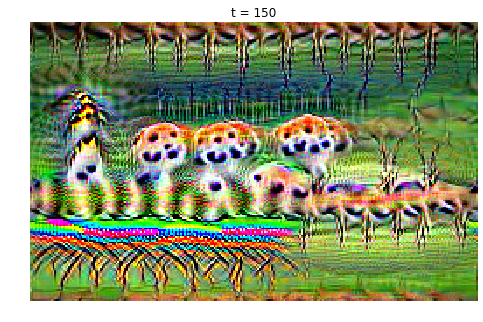

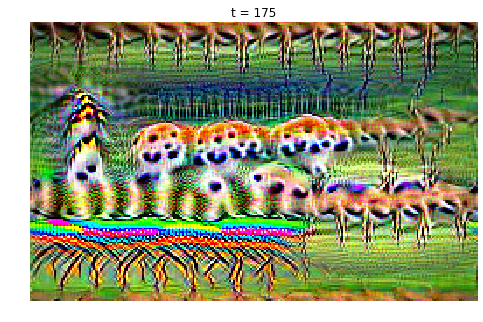

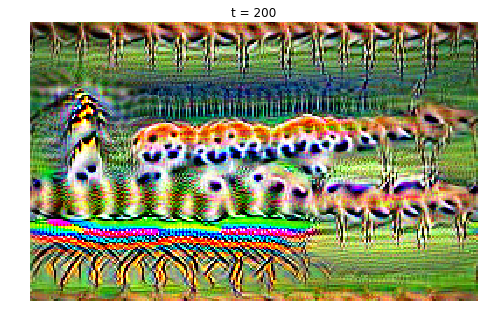

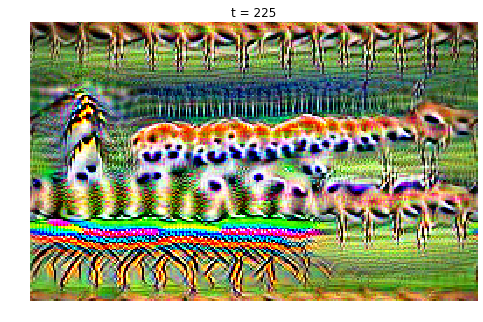

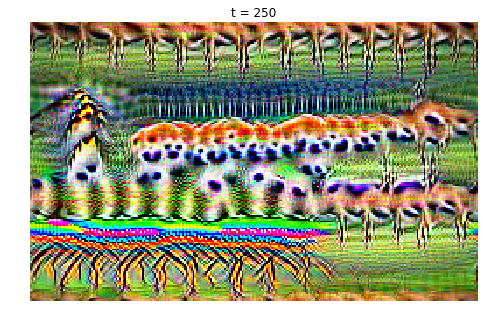

In [10]:
filename = 'ducks.jpeg'
max_size = 256
img = read_image(filename, max_size)
plt.imshow(img)
plt.axis('off')

# Preprocess the image by converting to float, transposing,
# and performing mean subtraction.
img_pre = preprocess_image(img, data['mean_image'], mean='pixel')

out = deepdream(img_pre, 7, model, 
                learning_rate=1e4, 
                num_iterations=300)

Here is a question, is the following statement true for you?

>Deep Dream images are interesting since I feel they reflect or echo, sometimes, how I might dream.

It is for me.